In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
raw_csv_data=pd.read_csv("malaysia_house_price_data_2025_label_encoded.csv")
df_encoded=raw_csv_data.copy()

# --- Split features and target ---
X = df_encoded.drop(columns='Median_Price')
y = df_encoded['Median_Price']

# Check target distribution
print("Target statistics:")
print(y.describe())
print(f"\nTarget range: {y.min():,.0f} to {y.max():,.0f}")

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Scale features - Using RobustScaler for better outlier handling ---
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- ALSO SCALE THE TARGET VARIABLE ---
# This is crucial! The target values are very large, causing numerical instability
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

print(f"\nScaled y_train range: {y_train_scaled.min():.2f} to {y_train_scaled.max():.2f}")


Target statistics:
count    2.000000e+03
mean     4.906854e+05
std      4.686322e+05
min      2.704900e+04
25%      2.699500e+05
50%      3.900000e+05
75%      5.735000e+05
max      1.142050e+07
Name: Median_Price, dtype: float64

Target range: 27,049 to 11,420,500

Scaled y_train range: -0.97 to 22.77


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# --- Define an improved model with batch normalization ---
model = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    
    # First hidden layer with batch normalization
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    # Second hidden layer
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    # Third hidden layer
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    # Fourth hidden layer
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.1),
    
    # Output layer
    layers.Dense(1)
])

# --- Compile with initial learning rate ---
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae', 'mse']
)

# --- Define callbacks ---
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

# --- Model summary ---
model.summary()


c:\Users\LIM TZE TA\AppData\Local\Programs\Python\Python311\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\LIM TZE TA\AppData\Local\Programs\Python\Python311\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\LIM TZE TA\AppData\Local\Programs\Python\Python311\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorfl

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,105 (184.00 KB)

 Trainable params: 46,209 (180.50 KB)

 Non-trainable params: 896 (3.50 KB)

In [3]:
# Train the model with scaled targets and callbacks
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_split=0.15,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 2.4064 - mae: 1.1666 - mse: 2.4064 - val_loss: 0.8817 - val_mae: 0.5288 - val_mse: 0.8817 - learning_rate: 0.0010
Epoch 2/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.5668 - mae: 0.7942 - mse: 1.5668 - val_loss: 0.8804 - val_mae: 0.5306 - val_mse: 0.8804 - learning_rate: 0.0010
Epoch 3/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.2912 - mae: 0.7434 - mse: 1.2912 - val_loss: 0.8433 - val_mae: 0.5243 - val_mse: 0.8433 - learning_rate: 0.0010
Epoch 4/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9610 - mae: 0.6578 - mse: 0.9610 - val_loss: 0.8238 - val_mae: 0.5141 - val_mse: 0.8238 - learning_rate: 0.0010
Epoch 5/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.9946 - mae: 0.6546 - mse: 0.9946 - val_loss: 0.8260 - val_mae: 0.5172 - val_mse: 0.8260 - learning_rate: 0.0010
Epoch 6/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.9059 - mae: 0.5952 - mse: 0.9059 - val_loss: 0.8190 - val_mae: 0.51

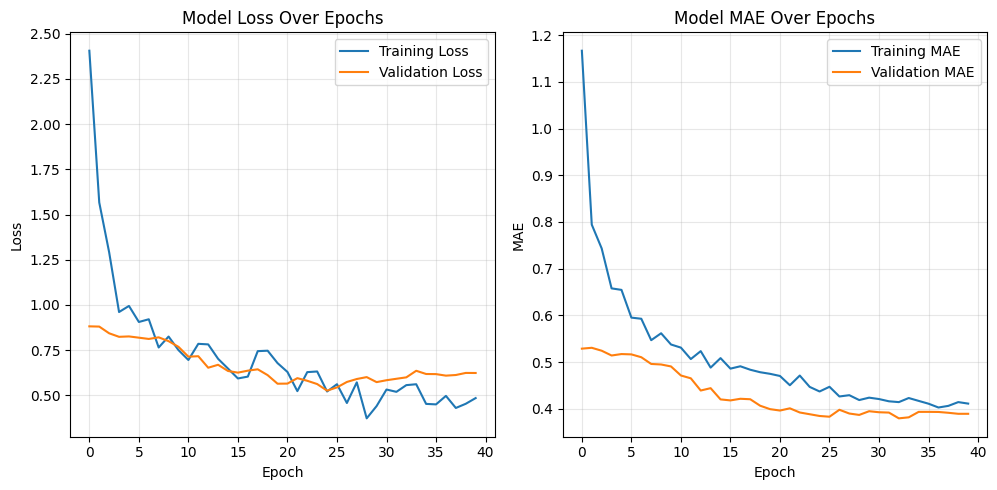

In [4]:
# Plot training history
plt.figure(figsize=(15, 5))

# Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# MAE
plt.subplot(1, 3, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

# Learning rate (if tracked)
if 'lr' in history.history:
    plt.subplot(1, 3, 3)
    plt.plot(history.history['lr'])
    plt.title('Learning Rate Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Make predictions on scaled data
y_pred_scaled = model.predict(X_test_scaled).flatten()

# Transform predictions back to original scale
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Compute metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Display results
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"\nMAE as percentage of mean: {(mae / y_test.mean()) * 100:.2f}%")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
MAE: 172752.15
RMSE: 331672.22
R²: 0.3747

MAE as percentage of mean: 35.68%


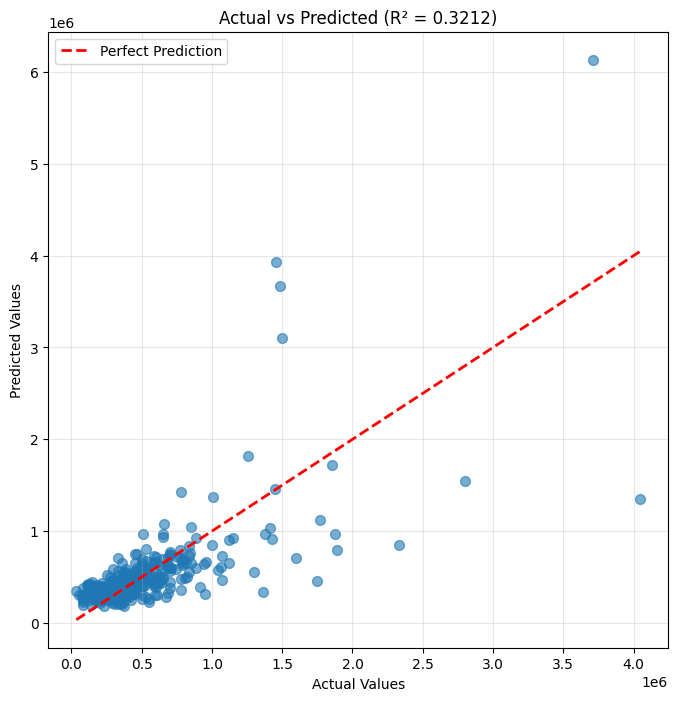

In [6]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.6, s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted (R² = {r2:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


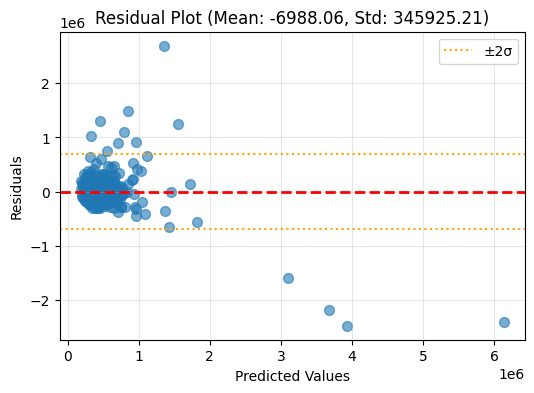

In [7]:
residuals = y_test - y_pred

# Calculate residual statistics
residual_mean = residuals.mean()
residual_std = residuals.std()

plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals, alpha=0.6, s=50)
plt.axhline(0, color='r', linestyle='--', lw=2)
plt.axhline(residual_mean + 2*residual_std, color='orange', linestyle=':', label='±2σ')
plt.axhline(residual_mean - 2*residual_std, color='orange', linestyle=':')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title(f'Residual Plot (Mean: {residual_mean:.2f}, Std: {residual_std:.2f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



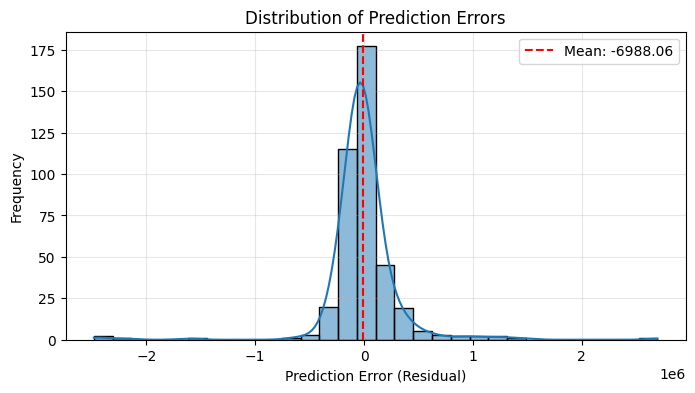

In [8]:
plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(residual_mean, color='r', linestyle='--', label=f'Mean: {residual_mean:.2f}')
plt.xlabel('Prediction Error (Residual)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


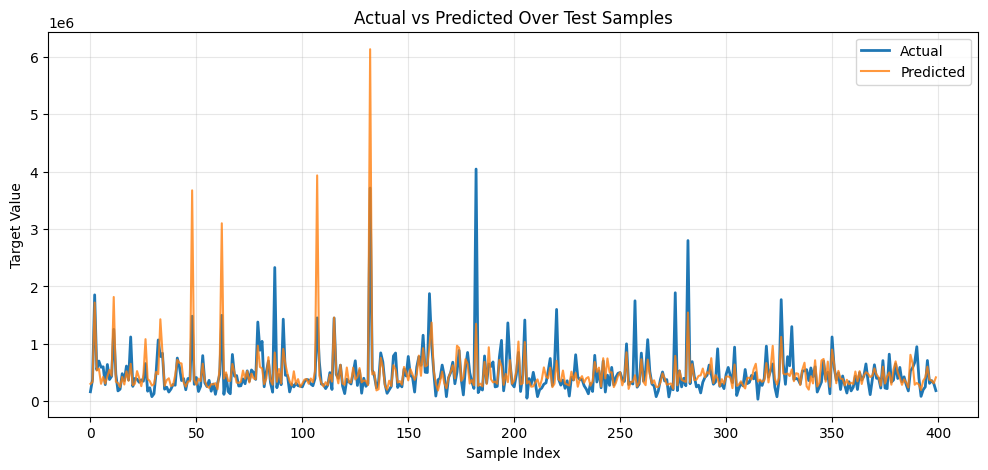

In [9]:
plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label='Actual', linewidth=2)
plt.plot(y_pred, label='Predicted', alpha=0.8, linewidth=1.5)
plt.title('Actual vs Predicted Over Test Samples')
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
